In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

# load files

In [2]:
# load adata files: samples of lung cancer cell lines exposure to gefitinib and erlotinib
infer_adata = sc.read_h5ad('l1000_sdst_egfri.h5ad')  
infer_adata

AnnData object with n_obs × n_vars = 29 × 978
    obs: 'sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'pert_id', 'pert_type', 'cell_iname', 'qc_pass', 'dyn_range', 'inv_level_10', 'build_name', 'failure_mode', 'project_code', 'cmap_name', 'n_replicates', 'pert_idx', 'cell_idx', 'tissue_idx', 'cell_pert_dose_time', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5', 'split_cold_drug_1', 'split_cold_drug_2', 'split_cold_drug_3', 'split_cold_drug_4', 'split_cold_drug_5', 'split_cold_cell_1', 'split_cold_cell_2', 'split_cold_cell_3', 'split_cold_cell_4', 'split_cold_cell_5', 'split_cold_cell_1_one_shot', 'split_cold_cell_1_0.1_shot', 'split_cold_cell_1_0.3_shot', 'split_cold_cell_1_0.5_shot', 'split_cold_cell_1_0.8_shot', 'split_cold_cell_2_one_shot', 'split_col

In [3]:
# Load attenion profile

input_file = "l1000_sdst_egfri_attention_scores.pkl"

with open(input_file, "rb") as f:
    attention_dict = pickle.load(f)
    
attention_dict_trt = attention_dict['trt']
attention_dict_ctl = attention_dict['ctl']

attention_dict_trt.keys(), attention_dict_ctl.keys()

(dict_keys(['CA_0', 'SA_1', 'SA_2', 'CA_3']),
 dict_keys(['SA_0', 'SA_1', 'SA_2', 'SA_3']))

In [4]:
# load drug smiles file
drug_smi = np.load('../../processed_data/all_drugs_idx2smi_8981.npy', allow_pickle=True).item()

# Define visualization functions

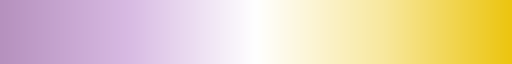

In [5]:
import matplotlib.colors as mcolors

colorlist = ["#B691BE", '#D8BAE3',  '#FFFFFF',  '#F8E89E', '#ECC50F']

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap", colorlist
)

custom_cmap

In [19]:
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from sklearn import preprocessing

def norm(vector):
    vector = np.array(vector, dtype=np.float64)
    min_val = np.min(vector)
    max_val = np.max(vector)

    if max_val == min_val: 
        return np.zeros_like(vector)
    
    return (vector - min_val) / (max_val - min_val)

def threshold_arr(arr, threshold):
    arr[arr < threshold] = 0
    return arr


def drawAttn(smi, attn_dict, idx_ls, layer, start_idx=4, save_path=None, size=(200,200), contourLines=4, beta=0.3):
    
    # For the start_idx parameter: 2 for SDST conditions; 4 for MDMT conditions

    mol = Chem.MolFromSmiles(smi)
    num_atom = mol.GetNumAtoms()
    
    if '+' not in layer:
        attn = np.array([attn_dict[layer][idx] for idx in idx_ls]).mean(axis=0).mean(axis=0)
        attn_arr = attn[:, start_idx:start_idx+num_atom]
        atom_attn = np.mean(attn_arr,0)
        atom_attn = norm(atom_attn)
    else:
        attn_1 = np.array([attn_dict["CA_0"][idx] for idx in idx_ls]).mean(axis=0).mean(axis=0)
        attn_arr_1 = attn_1[:, start_idx:start_idx+num_atom]
        atom_attn_1 = np.mean(attn_arr_1,0)
        atom_attn_1 = norm(atom_attn_1)
        
        attn_2 = np.array([attn_dict["CA_3"][idx] for idx in idx_ls]).mean(axis=0).mean(axis=0)
        attn_arr_2 = attn_2[:, start_idx:start_idx+num_atom]
        atom_attn_2 = np.mean(attn_arr_2,0)
        atom_attn_2 = norm(atom_attn_2)
        
        atom_attn = atom_attn_1+atom_attn_2

    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, atom_attn, contourLines=contourLines, alpha=beta, size=size,
                                                    colorMap=custom_cmap)
    
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300, format='png')
        fig.savefig(save_path.replace('.png', '.svg'), bbox_inches='tight', dpi=300, format='svg')

### gefitinib

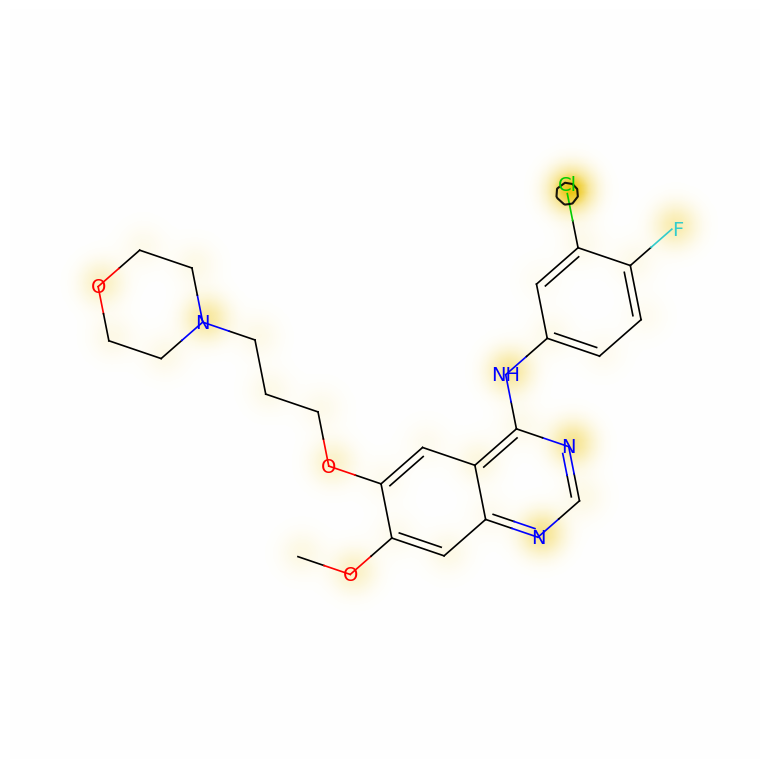

In [21]:
idx_ls = np.where(infer_adata.obs.cmap_name == 'gefitinib')[0]
drug_idx = infer_adata.obs.iloc[idx_ls[0], :]['pert_idx']
smi = drug_smi[drug_idx]
layer = 'CA_0+CA_3'

# save_path = f'attn_figs/gefitinib_layer_{layer}_mean.png'
save_path = None
fig = drawAttn(smi, attention_dict_trt, idx_ls, layer, start_idx=2, save_path=save_path, size=(300,300),
               contourLines=0, beta=0.9)

### erlotinib

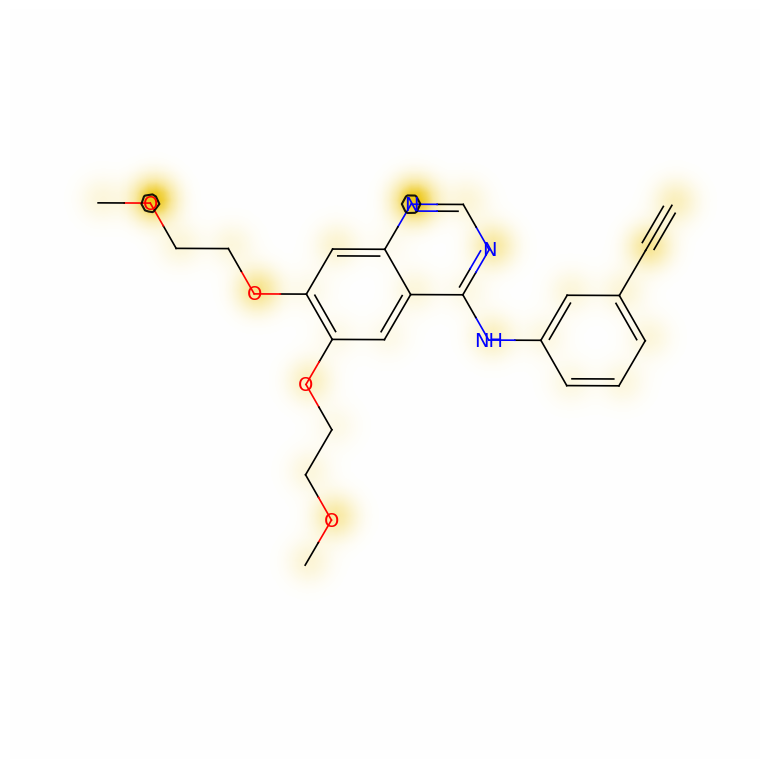

In [22]:
idx_ls = np.where(infer_adata.obs.cmap_name == 'erlotinib')[0]
drug_idx = infer_adata.obs.iloc[idx_ls[0], :]['pert_idx']
smi = drug_smi[drug_idx]

# save_path = f'attn_figs/gefitinib_layer_{layer}_mean.png'
save_path = None
fig = drawAttn(smi, attention_dict_trt, idx_ls, layer, start_idx=2, save_path=save_path, size=(300,300),
               contourLines=0, beta=0.9)